In [126]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tensorboard.backend.event_processing import event_accumulator
from IPython.display import clear_output

In [139]:

nice_expname = {'t1_all':'All',
                't1_cr-flair':'CR+Flair', 
                't1_cr-t2':'CR+T2', 
                't1_blurring-flair':'b-Flair',
                't1_blurring-t1':'b-T1',
                't1_blurring-t2':'b-T2', 
                't1_entropy':'Entropy', 
                't1_variance':'Variance',
                't1_curv':'Curv',
                't1':'None', 
                't1_thickness':'Thickness', 
                't1_sulc':'Sulc'}

# nice_expname = {'t1_all':'All',
#                 't1_cr-flair':'CR+Flr', 
#                 't1_cr-t2':'CR+T2', 
#                 't1_blurring-flair':'bFlr',
#                 't1_blurring-t1':'bT1',
#                 't1_blurring-t2':'bT2', 
#                 't1_entropy':'E', 
#                 't1_variance':'V',
#                 't1_curv':'C',
#                 't1':r'$\emptyset$', 
#                 't1_thickness':'Th', 
#                 't1_sulc':'S'}

nice_metricname = {'val_dice_score_epoch':'Dice',
                   'val_coverage_epoch':'True Positive',
                   'val_false_positive_epoch':'False Positive',
                   'val_false_negative_epoch': 'False Negative'}

In [29]:
experiments_root = '/workspace/RawData/FCDNet/logs/features_comparison/'

In [33]:
experiments_dirs = []
for exp_type in list(filter(lambda x: 't1' in x, os.listdir(experiments_root))):
    experiments_dir = os.path.join(experiments_root, exp_type)
    print(exp_type, len(os.listdir(experiments_dir)))
    experiments_dirs.append(experiments_dir)

t1_curv 5
t1_entropy 5
t1_blurring-t2 5
t1_blurring-t1 5
t1_cr-flair 5
t1_cr-t2 5
t1_variance 5
t1 5
t1_thickness 5
t1_sulc 6
t1_blurring-flair 5
t1_all 5


In [19]:
# !pip install tensorboard

In [ ]:
experiments_metrics = defaultdict(dict)
metrics_names = ['val_dice_score_epoch', 'val_coverage_epoch', 'val_false_positive_epoch', 'val_false_negative_epoch']
n_metrics = len(metrics_names)

# experiments_dir =  os.path.join(experiments_root, 't1_curv')
for experiments_dir in tqdm(experiments_dirs):
    
    exp_type = experiments_dir.split('/')[-1]

    for trial, experiment_name in tqdm(enumerate(os.listdir(experiments_dir))):
        experiment_path = os.path.join(experiments_dir, experiment_name)
        tb_path = os.path.join(experiment_path, 'tb')
        event_name = os.listdir(tb_path)[0]
        event_path = os.path.join(tb_path, event_name) # take an event file 
        ea = event_accumulator.EventAccumulator(event_path, 
                                                size_guidance={ 
                                                                event_accumulator.COMPRESSED_HISTOGRAMS: 0,
                                                                event_accumulator.IMAGES: 0,
                                                                event_accumulator.AUDIO: 0,
                                                                event_accumulator.SCALARS: 10**3,
                                                                event_accumulator.HISTOGRAMS: 0,
                                                               }
                                                )

        ea.Reload()

        metrics_dict = {}
        for metric_name in metrics_names:
            metrics_dict[metric_name] = np.array([event.value for event in ea.Scalars(metric_name)])

        print(f'{len(metrics_dict[metric_name])} epochs in {experiment_name} has found')

        experiments_metrics[exp_type][trial] = metrics_dict
        
clear_output()


In [77]:
learning_plots = False

# statistics [mean, std] for each (exp_type, metric_name) pair
stats_all = defaultdict(dict)

# iterate over different experiments e.g. [t1, t1+curv ,t1+cr, ...]
for exp_type, exp_trials in experiments_metrics.items():
    
    stat_points = defaultdict(list)
    if learning_plots:
        fig, axes = plt.subplots(nrows=1, ncols=n_metrics, figsize=(n_metrics*5,5), dpi=200)
    # over different trials of the same experiment
    for trial_num, trial_metrics in exp_trials.items():
        if trial_num > 4:
            break
        # over metrics within single trial
        for ax, metric_name in zip(axes, metrics_names):
            stat_points[metric_name].append(trial_metrics[metric_name][-20:])
            
            if learning_plots:
                ax.plot(trial_metrics[metric_name], label=trial)
                ax.set_title(metric_name)
    
    if learning_plots:
        fig.suptitle(exp_type, fontsize=20, color='blue')
        plt.show()
    
    for metric_name, metric_stat_points in stat_points.items():
        metric_stat_points_cat = np.concatenate(metric_stat_points)
        stats_all[metric_name][exp_type] = metric_stat_points_cat


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=n_metrics, figsize=(n_metrics*5,5), dpi=200)
for exp_type in experiments_metrics.keys():
    for metric_name in metrics_names:
        stats_all[exp_type][metric_name]

In [91]:
def fill_observation_dict(observation_dict, min_values=10):
    '''
    observation_dict - {'key_1', [...], ..., 'key_n', [...]}
    '''
    
    observation_dict_ = {}
    
    min_len = min([len(v) for k,v in observation_dict.items()])
    assert min_len >= min_values, f'Only {min_len} in some array!'
    
    for k,v in observation_dict.items():
        observation_dict_[k] = v[:min_len]
    
    return observation_dict_

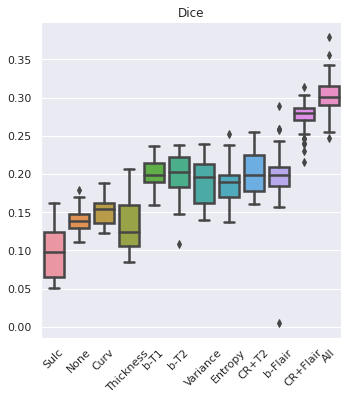

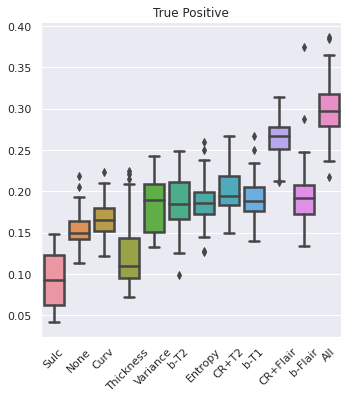

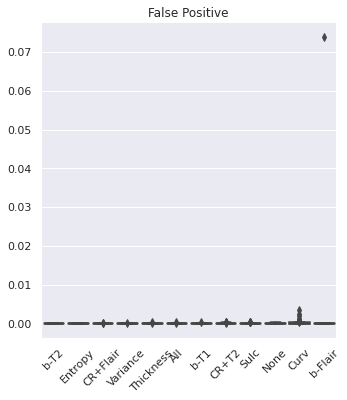

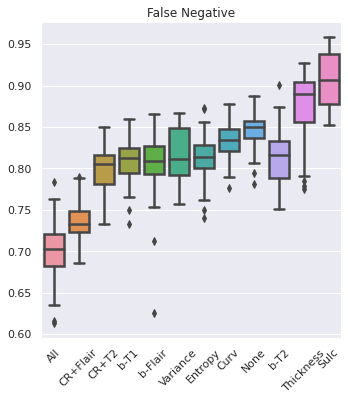

In [163]:
# sns.set(rc={'figure.figsize':(20,15),
#                 'font.size':40})

sns.axes_style("darkgrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
for metric_name in metrics:
    
    stats_metric_all = stats_all[metric_name]
    # df for specific metric across different experiments
    df_stats_metric = pd.DataFrame(fill_observation_dict(stats_metric_all), columns=stats_metric_all.keys())
    df_stats_metric = df_stats_metric.reindex(df_stats_metric.max().sort_values().index, axis=1)

    df_stats_metric = df_stats_metric.rename(columns=nice_expname)

    sns.catplot(kind="box", data=df_stats_metric)
    
    plt.title(nice_metricname[metric_name])
    plt.xticks(rotation=45)
    plt.show()